In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # set minimum logging to "info"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import utils
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
# needed to deserialize dataset
features_description = utils.get_features_description()
# result is a single scene with a dictionary where the keys are as defined in features_description (e.g. "state/current/x", "state/current/y"...etc
# def parse_example_basic(value):
#     decoded_example = tf.io.parse_single_example(value, features_description)
#     return decoded_example

In [3]:
# for example in dataset:
#     print(example)
#     for key, value in example.items():
#         print(f"Key: {key}")
#         print(f"Shape: {value.shape}")
#         print(f"Type: {type(value)}")
#         print("")
#     break

In [4]:
# put past, current and future states of each feature together
def _parse_states(decoded_example):    
    cyclist_present = decoded_example['state/type'] == 3
    cyclist_present = tf.reduce_any(cyclist_present)

    return cyclist_present

def parse_examples(examples):
    decoded_examples = tf.io.parse_single_example(examples, features_description)
    cyclist_present = _parse_states(decoded_examples)
    decoded_examples['cyclist_present'] = cyclist_present
    return decoded_examples

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value is tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
  """Returns a floast_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

In [5]:
for file in os.listdir('data'):
    FILES = [
    "./data/" + file,
    ]

    dataset = tf.data.TFRecordDataset(FILES) # make dataset
    dataset = dataset.map(parse_examples)
    original_size = len(list(dataset))
    cyclist_dataset = dataset.filter(lambda x: x['cyclist_present'] == True)
    
    writer = tf.io.TFRecordWriter("./data_cleaned/"+ file) #create a writer that'll store our data to disk

    count = 0
    for sample in cyclist_dataset:
        data = {

                "scenario/id": _bytes_feature(sample['scenario/id']),

                'roadgraph_samples/dir': _float_feature(sample['roadgraph_samples/dir'].numpy().ravel().tolist()),
                'roadgraph_samples/id': _int64_feature(sample['roadgraph_samples/id'].numpy().ravel().tolist()),
                "roadgraph_samples/type": _int64_feature(sample['roadgraph_samples/type'].numpy().ravel().tolist()),
                "roadgraph_samples/valid": _int64_feature(sample['roadgraph_samples/valid'].numpy().ravel().tolist()),
                "roadgraph_samples/xyz": _float_feature(sample['roadgraph_samples/xyz'].numpy().ravel().tolist()),

                'state/id': _float_feature(sample['state/id']),
                'state/type': _float_feature(sample['state/type']),
                'state/is_sdc': _int64_feature(sample['state/is_sdc']),
                'state/tracks_to_predict': _int64_feature(sample['state/tracks_to_predict']),

                'state/current/bbox_yaw' : _float_feature(sample['state/current/bbox_yaw']),
                'state/current/height' : _float_feature(sample['state/current/height']),
                'state/current/length' : _float_feature(sample['state/current/length']),
                'state/current/timestamp_micros': _int64_feature(sample['state/current/timestamp_micros'].numpy().ravel().tolist()),
                'state/current/valid': _int64_feature(sample['state/current/valid'].numpy().ravel().tolist()),
                'state/current/vel_yaw' : _float_feature(sample['state/current/vel_yaw']),
                'state/current/velocity_x' : _float_feature(sample['state/current/velocity_x']),
                'state/current/velocity_y' : _float_feature(sample['state/current/velocity_y']),
                'state/current/speed' : _float_feature(sample['state/current/speed']),
                'state/current/width' : _float_feature(sample['state/current/width']),
                'state/current/x' : _float_feature(sample['state/current/x']),
                'state/current/y' : _float_feature(sample['state/current/y']),
                'state/current/z' : _float_feature(sample['state/current/z']),

                'state/future/bbox_yaw' : _float_feature(sample['state/future/bbox_yaw'].numpy().ravel().tolist()),
                'state/future/height' : _float_feature(sample['state/future/height'].numpy().ravel().tolist()),
                'state/future/length' : _float_feature(sample['state/future/length'].numpy().ravel().tolist()),
                'state/future/timestamp_micros': _int64_feature(sample['state/future/timestamp_micros'].numpy().ravel().tolist()),
                'state/future/valid': _int64_feature(sample['state/future/valid'].numpy().ravel().tolist()),
                'state/future/vel_yaw' : _float_feature(sample['state/future/vel_yaw'].numpy().ravel().tolist()),
                'state/future/velocity_x' : _float_feature(sample['state/future/velocity_x'].numpy().ravel().tolist()),
                'state/future/velocity_y' : _float_feature(sample['state/future/velocity_y'].numpy().ravel().tolist()),
                'state/future/speed' : _float_feature(sample['state/future/speed'].numpy().ravel().tolist()),
                'state/future/width' : _float_feature(sample['state/future/width'].numpy().ravel().tolist()),
                'state/future/x' : _float_feature(sample['state/future/x'].numpy().ravel().tolist()),
                'state/future/y' : _float_feature(sample['state/future/y'].numpy().ravel().tolist()),
                'state/future/z' : _float_feature(sample['state/future/z'].numpy().ravel().tolist()),

                'state/past/bbox_yaw' : _float_feature(sample['state/past/bbox_yaw'].numpy().ravel().tolist()),
                'state/past/height' : _float_feature(sample['state/past/height'].numpy().ravel().tolist()),
                'state/past/length' : _float_feature(sample['state/past/length'].numpy().ravel().tolist()),
                'state/past/timestamp_micros': _int64_feature(sample['state/past/timestamp_micros'].numpy().ravel().tolist()),
                'state/past/valid': _int64_feature(sample['state/past/valid'].numpy().ravel().tolist()),
                'state/past/vel_yaw' : _float_feature(sample['state/past/vel_yaw'].numpy().ravel().tolist()),
                'state/past/velocity_x' : _float_feature(sample['state/past/velocity_x'].numpy().ravel().tolist()),
                'state/past/velocity_y' : _float_feature(sample['state/past/velocity_y'].numpy().ravel().tolist()),
                'state/past/speed' : _float_feature(sample['state/past/speed'].numpy().ravel().tolist()),
                'state/past/width' : _float_feature(sample['state/past/width'].numpy().ravel().tolist()),
                'state/past/x' : _float_feature(sample['state/past/x'].numpy().ravel().tolist()),
                'state/past/y' : _float_feature(sample['state/past/y'].numpy().ravel().tolist()),
                'state/past/z' : _float_feature(sample['state/past/z'].numpy().ravel().tolist()),

                'traffic_light_state/current/state': _int64_feature(sample['traffic_light_state/current/state'].numpy().ravel().tolist()),
                'traffic_light_state/current/valid': _int64_feature(sample['traffic_light_state/current/valid'].numpy().ravel().tolist()),
                'traffic_light_state/current/id': _int64_feature(sample['traffic_light_state/current/id'].numpy().ravel().tolist()),
                'traffic_light_state/current/x': _float_feature(sample['traffic_light_state/current/x'].numpy().ravel().tolist()),
                'traffic_light_state/current/y': _float_feature(sample['traffic_light_state/current/y'].numpy().ravel().tolist()),
                'traffic_light_state/current/z': _float_feature(sample['traffic_light_state/current/z'].numpy().ravel().tolist()),

                'traffic_light_state/past/state': _int64_feature(sample['traffic_light_state/past/state'].numpy().ravel().tolist()),
                'traffic_light_state/past/valid': _int64_feature(sample['traffic_light_state/past/valid'].numpy().ravel().tolist()),
                'traffic_light_state/past/x': _float_feature(sample['traffic_light_state/past/x'].numpy().ravel().tolist()),
                'traffic_light_state/past/y': _float_feature(sample['traffic_light_state/past/y'].numpy().ravel().tolist()),
                'traffic_light_state/past/z': _float_feature(sample['traffic_light_state/past/z'].numpy().ravel().tolist()),


        }

        out = tf.train.Example(features=tf.train.Features(feature=data))
        writer.write(out.SerializeToString())
        count += 1

    writer.close()
    print("Wrote "+ str(count) + " out of " + str(original_size) + " elements to TFRecord " + str(count/original_size))

Wrote 91 out of 312 elements to TFRecord 0.2916666666666667
Wrote 62 out of 281 elements to TFRecord 0.2206405693950178
Wrote 66 out of 292 elements to TFRecord 0.22602739726027396
Wrote 66 out of 314 elements to TFRecord 0.21019108280254778
Wrote 63 out of 276 elements to TFRecord 0.22826086956521738
Wrote 66 out of 323 elements to TFRecord 0.2043343653250774
Wrote 74 out of 318 elements to TFRecord 0.23270440251572327
Wrote 74 out of 292 elements to TFRecord 0.2534246575342466
Wrote 70 out of 279 elements to TFRecord 0.25089605734767023
Wrote 50 out of 263 elements to TFRecord 0.19011406844106463
Wrote 62 out of 293 elements to TFRecord 0.21160409556313994
Wrote 65 out of 277 elements to TFRecord 0.23465703971119134
Wrote 79 out of 306 elements to TFRecord 0.2581699346405229
Wrote 80 out of 284 elements to TFRecord 0.28169014084507044
Wrote 64 out of 304 elements to TFRecord 0.21052631578947367
Wrote 73 out of 286 elements to TFRecord 0.25524475524475526
Wrote 74 out of 290 elements 

In [21]:
import glob
total_images=0
train_files = sorted(os.listdir('D:/data/training/'))
print(train_files)
for f_i, file in enumerate(train_files):
    print(f_i) 
    total_images += sum([1 for _ in tf.compat.v1.io.tf_record_iterator('D:/data/training/' + file)])

['training_tfexample.tfrecord-00000-of-01000', 'training_tfexample.tfrecord-00001-of-01000', 'uncompressed_tf_example_training_training_tfexample.tfrecord-00002-of-01000', 'uncompressed_tf_example_training_training_tfexample.tfrecord-00003-of-01000', 'uncompressed_tf_example_training_training_tfexample.tfrecord-00004-of-01000', 'uncompressed_tf_example_training_training_tfexample.tfrecord-00005-of-01000', 'uncompressed_tf_example_training_training_tfexample.tfrecord-00006-of-01000', 'uncompressed_tf_example_training_training_tfexample.tfrecord-00007-of-01000', 'uncompressed_tf_example_training_training_tfexample.tfrecord-00008-of-01000', 'uncompressed_tf_example_training_training_tfexample.tfrecord-00009-of-01000', 'uncompressed_tf_example_training_training_tfexample.tfrecord-00010-of-01000', 'uncompressed_tf_example_training_training_tfexample.tfrecord-00011-of-01000', 'uncompressed_tf_example_training_training_tfexample.tfrecord-00012-of-01000', 'uncompressed_tf_example_training_trai

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


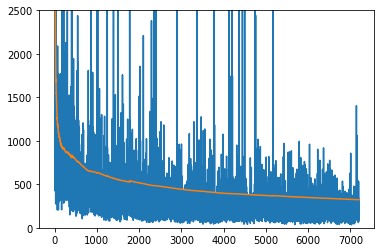

In [98]:
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

tf.disable_v2_behavior()
graph_points = []
for e in tf.train.summary_iterator("C:/Users/Laurens/Desktop/MasterThesis/waymo-motion-prediction-2021-main/model/logs/events.out.tfevents.1649610494.DESKTOP-5CFE17V.11400.0"):    
    for v in e.summary.value:
        if v.tag == 'train/loss':
            graph_points.append(v.simple_value)
points_average = []
i =1
for number in graph_points:
    points_average.append(sum(graph_points[0:i])/i)
    i+=1
    
plt.ylim((0,2500))
plt.plot(graph_points)
plt.plot(points_average)

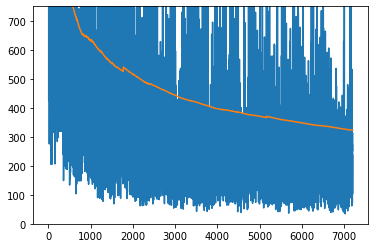

In [99]:
plt.ylim((0,750))
plt.plot(graph_points)
plt.plot(points_average)